# [Clasificar artículos en temas con LDA](https://www.youtube.com/watch?v=aUJi-qJ-Et8&list=PL7HAy5R0ehQVdPVLV6pIJA9ZE2vVyLRxX&index=41)

El **LDA ("Lane Directly Allocation")** es un método de modelado de temas que identifica temas latentes en un conjunto de documentos.  
Utiliza la distribución de Dirichlet para determinar la probabilidad de que ciertas palabras aparezcan juntas en documentos y, por lo tanto, pueden ser consideradas como parte del mismo "tema".  
A grandes rasgos, el LDA trata de determinar qué palabras son más probables que aparezcan en los mismos documentos y, basándose en eso, decide que documentos tratan sobre qué temas.

Usos:
* Descubrimiento de temas
* Reducción de la dimensionalidad
* Recomendaciones

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
# nltk.download('stopwords')

In [7]:
stops_español = set(stopwords.words('spanish'))

In [8]:
stops_español

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

In [9]:
stops_español = stops_español.union({"así", "si", "hacer", "cosas","creo", "cómo", "solo", "aquí", "risas",
                                    "ser", "años", "gente","vez", "historia", "ahora", "entonces", "bien", "puede", 
                                    "pueden", "bueno", "aplauso", "aplausos","ee","uu", "datos", "personas", 
                                    "hace", "hoy", "cada", "podemos", "ver", "dos", "luego", "hecho", "realmente",
                                    "tan","decir", "saben", "ustedes","dijo", "voy", "quiero", "bf", "dh", "número",
                                    "des", "gran", "día", "puedo", "mismo", "tres", "hombres", "mujeres", "hombre", "mujer",
                                    "hacia", "sólo", "manera", "tipo", "mejor", "tener", "alguien", "después","gracias",
                                    "menos", "ejemplo", "parte", "respuesta", "forma", "todas", "muchas", "lugar", "poder",
                                    "incluso", "sino", "idea", "nunca", "dije", "momento", "siempre", "podría", "veces", "ahí",
                                    "sido", "allí", "dice", "va"})

In [10]:
stops_español = list(stops_español)
stops_español

['tuviésemos',
 'estabas',
 'hubimos',
 'hubiesen',
 'tenía',
 'estaban',
 'hubieras',
 'fueses',
 'estarías',
 'estos',
 'tuya',
 'tiene',
 'ustedes',
 'hubo',
 'cosas',
 'tuyos',
 'estuviera',
 'éramos',
 'estadas',
 'podría',
 'te',
 'hayáis',
 'habiendo',
 'fuesen',
 'incluso',
 'tipo',
 'hecho',
 'tuviera',
 'serás',
 'es',
 'dijo',
 'habéis',
 'nuestro',
 'habré',
 'historia',
 'os',
 'ver',
 'sobre',
 'lugar',
 'desde',
 'fuese',
 'hombre',
 'hombres',
 'eres',
 'fueran',
 'se',
 'tendrá',
 'alguien',
 'otra',
 'más',
 'uno',
 'mis',
 'has',
 'hubiéramos',
 'unos',
 'sin',
 'habidas',
 'tuvierais',
 'gracias',
 'estuvieseis',
 'tendré',
 'como',
 'aquí',
 'fuéramos',
 'tenían',
 'siente',
 'habías',
 'seré',
 'será',
 'habrán',
 'que',
 'ellos',
 'fueseis',
 'erais',
 'sea',
 'para',
 'fuimos',
 'suyos',
 'cada',
 'estaréis',
 'ee',
 'haya',
 'mismo',
 'hubieseis',
 'ante',
 'vuestro',
 'serían',
 'míos',
 'dh',
 'todas',
 'estuvimos',
 'estuviéramos',
 'muy',
 'teniendo',
 'rea

In [11]:
df = pd.read_csv('ted_talks_es.csv')

In [12]:
df

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Al Gore sobre cómo evitar la crisis climática,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523396,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,Con el mismo humor y humanidad que irradió en ...,Muchas gracias Chris. Y es en verdad un gran h...
1,7,"David Pogue dice ""La Simplicidad Vende""",David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920803,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,"El columnista del New York Times, David Pogue,...","Hola contestadora automática, mi vieja amiga. ..."
2,53,Un recorrido por la renovación urbana de la ma...,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664029,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"En una charla altamente emotiva, la activista ...","Si están presentes aquí hoy, y estoy muy conte..."
3,66,Ken Robinson dice que las escuelas matan la cr...,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65052534,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson plantea de manera entretenida...,"Buenos días. ¿Cómo están? Ha sido increíble, ¿..."
4,92,Hans Rosling nos muestra las mejores estadísti...,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501766,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,Una manera única de presentar datos. Con la en...,"Hace unos 10 años, emprendí la tarea de enseña..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,60135,Lo que falta en la narrativa de los inmigrante...,Elizabeth Camarillo Gutierrez,{0: 'Elizabeth Camarillo Gutierrez'},{0: ['analyst']},{0: 'Elizabeth Camarillo Gutierrez is a corpor...,594541,2020-02-05,2020-04-21,TED@WellsFargo,en,"['en', 'es']",15.0,653,"['life', 'society', 'immigration', 'humanity',...",{50657: 'A personal plea for humanity at the U...,https://www.ted.com/talks/elizabeth_camarillo_...,Al contar su historia de encontrar oportunidad...,"Hola a todos, me llamo Elizabeth y trabajo en ..."
3917,62707,El ciclo vital de una zapatilla - Angel Chang,Angel Chang,{0: 'Angel Chang'},NaN,{0: 'Angel Chang is a womenswear designer work...,219254,2020-04-23,2020-04-23,TED-Ed,en,"['el', 'en', 'es', 'fr', 'ko', 'pt', 'pt-br']",NaN,303,"['TED-Ed', 'education', 'animation', 'fashion'...",{2756: 'What really happens to the plastic you...,https://www.ted.com/talks/angel_chang_the_wild...,Ver la lección completa en: https://ed.ted.co...,"Los australianos los llaman ""runners"". Los bri..."
3918,62341,"No descuides tus emociones, exprésal

In [13]:
df["transcript"][0]

'Muchas gracias Chris. Y es en verdad un gran honor tener la oportunidad de venir a este escenario por segunda vez. Estoy extremadamente agradecido. He quedado conmovido por esta conferencia, y deseo agradecer a todos ustedes sus amables comentarios acerca de lo que tenía que decir la otra noche. Y digo eso sinceramente, en parte porque — (Sollozos fingidos) — ¡lo necesito! (Risas) ¡Pónganse en mi posición! Volé en el avión vicepresidencial por ocho años. ¡Ahora tengo que quitarme mis zapatos o botas para subirme a un avión! (Risas) (Aplausos) Les diré una rápida historia para ilustrar lo que ha sido para mí. Es una historia verdadera — cada parte de esto es verdad. Poco después de que Tipper y yo dejamos la — (Sollozos fingidos) — Casa Blanca — (Risas) — estábamos viajando desde nuestra casa en Nashville a una pequeña granja que tenemos 50 millas al este de Nashville — conduciendo nosotros mismos. Sé que suena como cualquier cosa para ustedes, pero — (Risas) — miré en el retrovisor y 

In [14]:
vectorizer = CountVectorizer(stop_words=stops_español)

In [15]:
X = vectorizer.fit_transform(df['transcript'])

In [16]:
X

<3921x111271 sparse matrix of type '<class 'numpy.int64'>'
	with 1889073 stored elements in Compressed Sparse Row format>

In [17]:
#111358

In [18]:
# Agrupa todos los vectores por cercanía en 10 clusters
lda = LatentDirichletAllocation(
    n_components=10, # default: 10
    random_state=12354,
)

In [19]:
lda.fit(X)

LatentDirichletAllocation(random_state=12354)

In [20]:
def graficar_palabras_top (model, feature_names, n_top_words=10):   
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]   
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Tema {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('LDA', fontsize=40)   
    
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [21]:
palabras = vectorizer.get_feature_names_out()


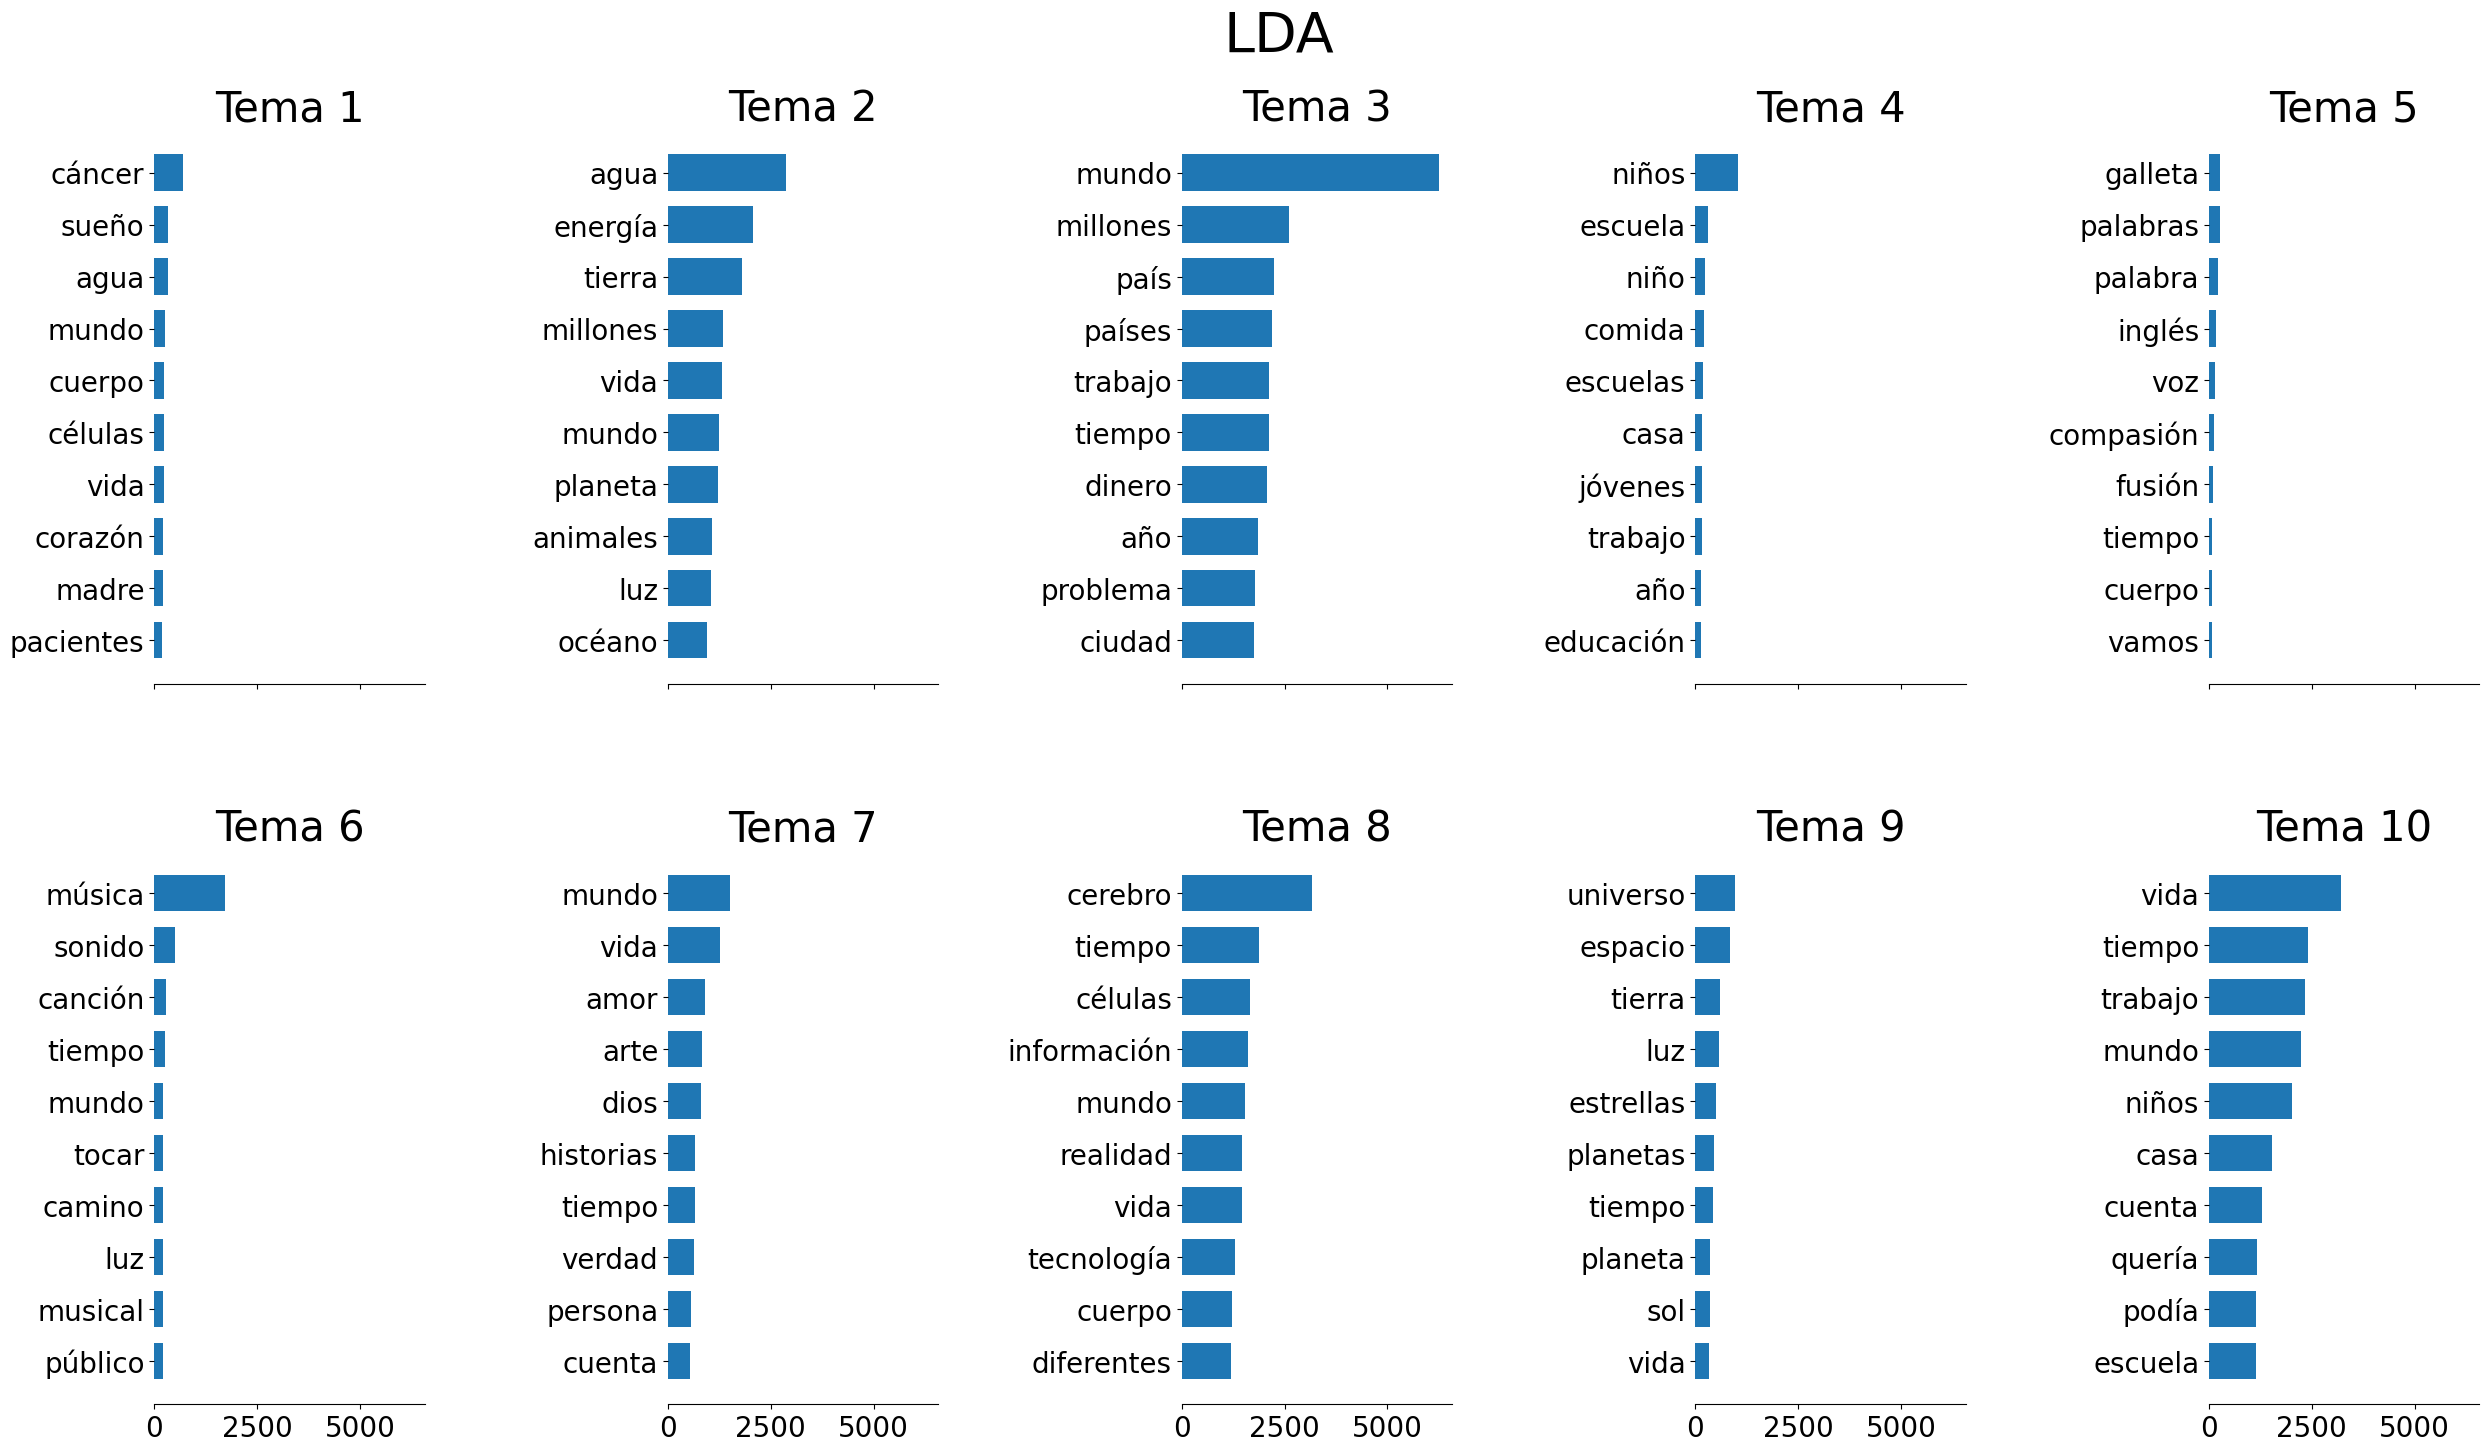

In [22]:
graficar_palabras_top(lda, palabras);

In [23]:
Z = lda.transform(X)

2460


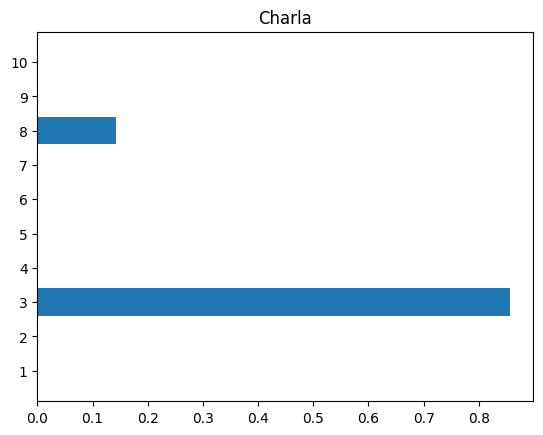

In [24]:
np.random.seed(1111)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title("Charla");
print(i)

In [25]:
def wrap(x):
    return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

print(wrap(df.iloc[i]['transcript']))

Hoy voy a hablar de tecnología y de la sociedad.  El Departamento de
Transporte estimó que, el año pasado, hubo 35 000 muertos en
accidentes de auto, tan solo en EE.UU. A nivel mundial, mueren 1,2
millones de personas por año en accidentes de auto.  Si hubiera una
manera de eliminar el 90 % de esos accidentes, ¿apoyarían la causa?
Por supuesto que lo harían.  Esto es lo que promete la tecnología de
vehículos autónomos, al eliminar la principal causa de accidentes: el
error humano.  Imagínense en el año 2030, viajando en un vehículo
autónomo, sentados, mirando este video vintage de un evento
TEDxCambridge.  (Risas) De pronto, el auto tiene una falla mecánica y
no puede detenerse.  Si el auto continúa, va a atropellar a un grupo
de peatones que cruza la calle.  Pero el auto puede cambiar de
dirección, atropellar a un solo transeúnte, matarlo, y así salvar a
los peatones.  ¿Qué debería hacer el auto, y quién debería decidir?
¿Y si en cambio el auto pudiera irse contra una pared, chocar y


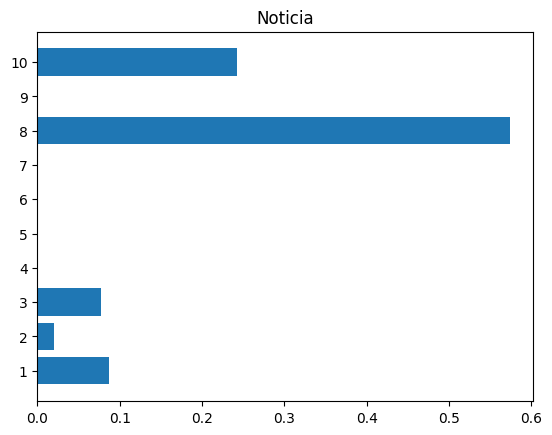

In [26]:
np.random.seed(1548)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title("Noticia");

In [27]:
print(wrap(df.iloc[i]['transcript']))

Bien, soy doctor, pero me incliné hacia la investigación y ahora soy
epidemiólogo.  La verdad es que nadie sabe bien qué es la
epidemiología.  Es la ciencia para saber en el mundo real si algo es
bueno o malo para uno.  Se entiende mejor con un ejemplo: es la
ciencia de los titulares descabellados en los periódicos.  Veamos
ejemplos.  Esto es del Daily Mail.  Cada país tiene un periódico así.
Tiene un proyecto filosófico estrafalario en curso de dividir los
objetos inanimados del mundo en los que previenen o los que provocan
cáncer.  Estas son cosas que dijeron recientemente que provocan
cáncer: divorcio, wi-fi, artículos de aseo y café. Y estas dijeron que
lo previenen: corteza, pimienta roja, regaliz y café. Ya pueden ver
que hay contradicciones.  El café provoca y previene el cáncer.  Y, a
medida que continúan leyendo, pueden observar que quizá haya alguna
forma de valencia política detrás de esto.  Para las mujeres, los
quehaceres previenen el cáncer de mama, pero, para los hombres